<a href="https://colab.research.google.com/github/yeonchae62/REU_Project/blob/main/GenerateFixationData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Usage guide

Open the **table of contents** and find all headers that have `TODO:` within them. Only those sections will need to be updated to process a new report.

The usual procedure to process a report might look like:

1. Set the report files in `TODO: Import required files`.
2. Set the start and end times of the target interval of interest in `TODO: Start and end times`.
3. Select `Runtime > Run all` (or press `Ctrl+F9`) to run all code cells.
4. The results of the analysis will be at the bottom of the `Results` section, just before `TODO: Visualizing the results`.
5. If a report file has more than one target interval of interest, repeat steps 2-5. In this case, only running the cells after the `TODO: Start and end times` section will be necessary.

# Set up dependencies

In [ ]:
from bisect import bisect_left
import copy
import csv
import cv2
import math
import numpy as np
import os
import pandas as pd
from pathlib import Path
import shutil
from google.colab import drive
from google.colab.patches import cv2_imshow
drive.mount('/content/drive')

Mounted at /content/drive


## **TODO**: Import required files

In [ ]:
%cd ~/

# load needed files from Google Drive
# TODO: change path to directory containing files
BASE_DRIVE_DIR = Path('/content/drive/MyDrive/Texas A&M/Research Meeting TAMU/Research Meeting_Backup/Tam/Testing-Yeon/')
MARKER_DRIVE_DIR = BASE_DRIVE_DIR.joinpath('Marker/')
GAZE_DRIVE_DIR = BASE_DRIVE_DIR

# TODO: change filenames to those containing (1) the square markers marking the
# viewport, and (2) the participant's gaze data
MARKER_FILE = Path('Testing_MARKER-MAPPER_Boundary_csv.zip')
GAZE_FILE = Path('raw-data-export (2).zip')

if not os.path.exists('data-processing'):
    os.mkdir('data-processing')

shutil.copy2(MARKER_DRIVE_DIR.joinpath(MARKER_FILE), 'data-processing')
shutil.copy2(GAZE_DRIVE_DIR.joinpath(GAZE_FILE), 'data-processing')

/root


'data-processing/raw-data-export (2).zip'

In [ ]:
%cd data-processing
!for zip_file in *.zip; do unzip -n -d "${zip_file%.zip}" "$zip_file"; done

/root/data-processing
Archive:  raw-data-export (2).zip
  inflating: raw-data-export (2)/005_agrim_b_bas_2023-09-07_13-11-21-b20af902/info.json  
  inflating: raw-data-export (2)/005_agrim_b_bas_2023-09-07_13-11-21-b20af902/gaze.csv  
  inflating: raw-data-export (2)/005_agrim_b_bas_2023-09-07_13-11-21-b20af902/3d_eye_states.csv  
  inflating: raw-data-export (2)/005_agrim_b_bas_2023-09-07_13-11-21-b20af902/imu.csv  
  inflating: raw-data-export (2)/005_agrim_b_bas_2023-09-07_13-11-21-b20af902/scene_camera.json  
  inflating: raw-data-export (2)/005_agrim_b_bas_2023-09-07_13-11-21-b20af902/events.csv  
  inflating: raw-data-export (2)/005_agrim_b_bas_2023-09-07_13-11-21-b20af902/fixations.csv  
  inflating: raw-data-export (2)/005_agrim_b_bas_2023-09-07_13-11-21-b20af902/blinks.csv  
  inflating: raw-data-export (2)/005_agrim_b_bas_2023-09-07_13-11-21-b20af902/world_timestamps.csv  
  inflating: raw-data-export (2)/005_agrim_b_bas_2023-09-07_13-11-21-b20af902/073ec979_0.0-591.89.mp4  


# Pre-process marker data

## Define structures

In [ ]:
# @title
class Time:
    '''
    A measurement of time.

    Internally, time is stored in nanoseconds. However, this class can be used
    to query for any needed unit of time.

    Addition, subtraction, and all comparison operators are implemented for this
    class for convenience. Division is implemented as well, however the result
    will be a float.
    '''
    def __init__(self, nanoseconds: int | float):
        self.nanoseconds = nanoseconds

    @staticmethod
    def from_ms(milliseconds: int | float) -> 'Time':
        '''
        Creates a Time instance with the given number of milliseconds.
        '''
        return Time(milliseconds * 1e+6)

    @staticmethod
    def from_sec(seconds: int | float) -> 'Time':
        '''
        Creates a Time instance with the given number of seconds.
        '''
        return Time(seconds * 1e+9)

    def __add__(self, other) -> 'Time':
        return Time(self.nanoseconds + other.nanoseconds)

    def __sub__(self, other) -> 'Time':
        return Time(self.nanoseconds - other.nanoseconds)

    def __truediv__(self, other) -> float:
        return self.nanoseconds / other.nanoseconds

    def __lt__(self, other) -> bool:
        return self.nanoseconds < other.nanoseconds

    def __le__(self, other) -> bool:
        return self.nanoseconds <= other.nanoseconds

    def __gt__(self, other) -> bool:
        return self.nanoseconds > other.nanoseconds

    def __ge__(self, other) -> bool:
        return self.nanoseconds >= other.nanoseconds

    def __eq__(self, other) -> bool:
        return self.nanoseconds == other.nanoseconds

    def __ne__(self, other) -> bool:
        return self.nanoseconds != other.nanoseconds

    def copy(self) -> 'Time':
        '''
        Returns an exact copy of this time instance.
        '''
        return Time(self.nanoseconds)

    def ns(self) -> float:
        '''
        Returns the number of nanoseconds stored in this time object.
        '''
        return self.nanoseconds

    def ms(self) -> float:
        '''
        Returns the number of milliseconds stored in this time object.
        '''
        return self.nanoseconds / 1e+6

    def sec(self) -> float:
        '''
        Returns the number of seconds stored in this time object.
        '''
        return self.nanoseconds / 1e+9

    def __repr__(self) -> str:
        return f'Time({self.nanoseconds})'

    def __str__(self) -> str:
        min = int(self.sec() // 60)
        raw_sec = self.sec() % 60
        sec = int(raw_sec)
        millis = int((raw_sec - sec) * 1000)

        sec_str = str(sec).rjust(2, '0')
        millis_str = str(millis).rjust(3, '0')
        return f'{min}:{sec_str}.{millis_str}'

In [ ]:
# @title
def is_nan(t: tuple[float, float]) -> bool:
    '''
    Returns true if the given 2D vector contains a nan component.
    '''
    return math.isnan(t[0]) or math.isnan(t[1])

class Timepoint:
    '''
    Represents the position of all four markers at a given timepoint.

    Iterating over the timepoint yields all four coordinates of the timepoint in
    clockwise order, starting from the top left.
    '''
    def __init__(
        self,
        timestamp: Time,
        top_left: tuple[float, float],
        top_right: tuple[float, float],
        bottom_right: tuple[float, float],
        bottom_left: tuple[float, float],
    ):
        self.timestamp = timestamp
        self.top_left = top_left
        self.top_right = top_right
        self.bottom_right = bottom_right
        self.bottom_left = bottom_left

    def __iter__(self):
        yield self.top_left
        yield self.top_right
        yield self.bottom_right
        yield self.bottom_left

    def __len__(self) -> int:
        return 4

    def __getitem__(self, key) -> tuple[float, float]:
        '''
        Allows you to index this Timepoint like a tuple, in tandem with
        `__setitem__`.
        '''
        if key == 0:
            return self.top_left
        elif key == 1:
            return self.top_right
        elif key == 2:
            return self.bottom_right
        elif key == 3:
            return self.bottom_left
        else:
            raise IndexError('index out of range')

    def __setitem__(self, key, value):
        '''
        Allows you to index this Timepoint like a tuple, in tandem with
        `__getitem__`.
        '''
        if key == 0:
            self.top_left = value
        elif key == 1:
            self.top_right = value
        elif key == 2:
            self.bottom_right = value
        elif key == 3:
            self.bottom_left = value
        else:
            raise IndexError('index out of range')

    def copy(self) -> 'Timepoint':
        '''
        Returns an exact copy of this timepoint.
        '''
        return Timepoint(
            self.timestamp.copy(),
            self.top_left,
            self.top_right,
            self.bottom_right,
            self.bottom_left,
        )

    def num_set(self) -> int:
        '''
        Returns the number of non-nan coordinates in this timepoint. The ideal
        number is four or three.
        '''
        return len([coord for coord in self if not is_nan(coord)])

    def fill_missing(self) -> 'Timepoint':
        '''
        If this timepoint has exactly one corner of its top left, top right,
        bottom right, and bottom left corners missing, return a new timepoint
        with the missing corner inserted in.

        Otherwise, an unchanged copy of the timepoint is returned.

        :param timepoint: The timepoint to fill. This original timepoint will
            NOT be mutated.
        '''
        # ensure only one corner is missing before going through
        num_set = self.num_set()
        if num_set != 3:
            return self.copy()

        top_left, top_right, bottom_right, bottom_left = tuple(self)

        if is_nan(top_left) or is_nan(top_right):
            distance = (
                bottom_right[0] - bottom_left[0],
                bottom_right[1] - bottom_left[1],
            )

            if is_nan(top_left):
                top_left = (
                    top_right[0] - distance[0],
                    top_right[1] - distance[1],
                )
            else:
                top_right = (
                    top_left[0] + distance[0],
                    top_left[1] + distance[1],
                )
        else:
            distance = (
                top_right[0] - top_left[0],
                top_right[1] - top_left[1],
            )

            if is_nan(bottom_left):
                bottom_left = (
                    bottom_right[0] - distance[0],
                    bottom_right[1] - distance[1],
                )
            else:
                bottom_right = (
                    bottom_left[0] + distance[0],
                    bottom_left[1] + distance[1],
                )

        return Timepoint(
            self.timestamp.copy(),
            top_left,
            top_right,
            bottom_right,
            bottom_left,
        )

    def __repr__(self) -> str:
        return f'Timepoint({self.timestamp.ns()}, {self.top_left}, {self.top_right}, {self.bottom_right}, {self.bottom_left})'

    def __str__(self) -> str:
        return f'{self.timestamp}: tl={self.top_left}, tr={self.top_right}, br={self.bottom_right}, bl={self.bottom_left}'

In [ ]:
# @title
class Gaze:
    '''
    Represents the gaze of a participant at a given timepoint.
    '''
    def __init__(
        self,
        timestamp: Time,
        point: tuple[float, float],
        fixation_id: int | None,
    ):
        self.timestamp = timestamp
        self.point = point
        self.fixation_id = fixation_id

    def copy(self) -> 'Gaze':
        '''
        Returns an exact copy of this Gaze object.
        '''
        return Gaze(self.timestamp.copy(), self.point, self.fixation_id)

    def __repr__(self) -> str:
        if self.fixation_id == None:
            return f'Gaze({self.timestamp.ns()}, {self.point}, n/a)'
        else:
            return f'Gaze({self.timestamp.ns()}, {self.point}, fixated {self.fixation_id})'

    def __str__(self) -> str:
        if self.fixation_id == None:
            return f'{self.timestamp}: gazed at={self.point}'
        else:
            return f'{self.timestamp}: gazed at={self.point}, fixated ({self.fixation_id})'

## Collect data

In [ ]:
# @title
# load gaze data and make note of the target participant's section id
SECTION_ID = ''
gaze_dir = Path(GAZE_FILE.stem)

# get first subdirectory
GAZE_DATA_DIR = next(iter([fd for fd in gaze_dir.iterdir() if fd.is_dir()]))

with open(GAZE_DATA_DIR.joinpath('gaze.csv')) as f:
    reader = csv.reader(f)

    # skip header
    print(next(reader))

    # header schema:
    # [
    #     0: 'section id',
    #     1: 'recording id',
    #     2: 'timestamp [ns]',
    #     3: 'gaze x [px]',
    #     4: 'gaze y [px]',
    #     5: 'worn',
    #     6: 'fixation id',
    #     7: 'blink id',
    #     8: 'azimuth [deg]',
    #     9: 'elevation [deg]'
    # ]
    #
    # 6: 'fixation id' and 7: 'blink id' can be unavailable, and are only set
    # if the participant looks at a fixation point or blinks, respectively
    gazes: list[Gaze] = []
    for row in reader:
        if SECTION_ID != '' and row[0] != SECTION_ID:
            # we shouldn't get here for this file
            # but this is here just in case, since I'm unaware of the format of this file
            raise Exception('gaze.csv contains multiple section IDs')
        else:
            SECTION_ID = row[0]

        # replace empty strings with nan
        row = ['nan' if x == '' else x for x in row]

        # extract gaze coordinates
        gazes.append(Gaze(
            Time(int(row[2])), # timestamp
            (float(row[3]), float(row[4])), # gaze position
            None if row[6] == 'nan' else int(row[6]), # fixation id
        ))

print(f'Detected section ID: {SECTION_ID}')
print(f'Number of gaze points: {len(gazes)}')
print(f'Time covered: {(gazes[-1].timestamp - gazes[0].timestamp).sec()} sec')

['section id', 'recording id', 'timestamp [ns]', 'gaze x [px]', 'gaze y [px]', 'worn', 'fixation id', 'blink id', 'azimuth [deg]', 'elevation [deg]']
Detected section ID: 073ec979-7fa3-411f-8858-fd354d7ab7ac
Number of gaze points: 117137
Time covered: 591.438259 sec


In [ ]:
# @title
# load the marker data
# strip .zip from marker filename to get directory name
with open(Path(MARKER_FILE.stem).joinpath('surface_positions.csv')) as f:
    reader = csv.reader(f)

    # skip header
    print(next(reader))

    # header schema:
    # [
    #     0: 'section id',
    #     1: 'timestamp [ns]',
    #     2: 'detected marker IDs',
    #     3: 'tl x [px]',
    #     4: 'tl y [px]',
    #     5: 'tr x [px]',
    #     6: 'tr y [px]',
    #     7: 'br x [px]',
    #     8: 'br y [px]',
    #     9: 'bl x [px]',
    #     10: 'bl y [px]',
    # ]
    timepoints: list[Timepoint] = []
    for row in reader:
        if row[0] != SECTION_ID:
            continue

        # replace empty strings with nan
        row = ['nan' if x == '' else x for x in row]

        # try to filter out duplicate timestamps
        # there was a SINGLE duplicate timestamp in the kaison data set which
        # broke later calculations :(
        timestamp = Time(int(row[1]))
        if len(timepoints) > 0:
            if timestamp == timepoints[-1].timestamp:
                continue

        # extract coordinates of markers
        timepoints.append(Timepoint(
            timestamp,
            (float(row[3]), float(row[4])), # top left
            (float(row[5]), float(row[6])), # top right
            (float(row[7]), float(row[8])), # bottom right
            (float(row[9]), float(row[10])), # bottom left
        ))

print(f'Number of marker timepoints: {len(timepoints)}')
print(f'Time covered: {(timepoints[-1].timestamp - timepoints[0].timestamp).sec()} sec')

['section id', 'timestamp [ns]', 'detected marker IDs', 'tl x [px]', 'tl y [px]', 'tr x [px]', 'tr y [px]', 'br x [px]', 'br y [px]', 'bl x [px]', 'bl y [px]']
Number of marker timepoints: 17372
Time covered: 590.92411 sec


# Create utility functions

## Math

In [ ]:
def lerp(a: float, b: float, t: float) -> float:
    '''
    Linearly interpolates between a and b by t.
    '''
    return a + (b - a) * t

def lerp_vec(a: tuple[float, float], b: tuple[float, float], t: float) -> tuple[float, float]:
    '''
    Linearly interpolates between a and b by t, where a and b are 2D vectors.
    '''
    return (
        lerp(a[0], b[0], t),
        lerp(a[1], b[1], t),
    )

def as_int(v: tuple[float, float]) -> tuple[int, int]:
    '''
    Converts the given float vector to an integer vector.
    '''
    return (int(v[0]), int(v[1]))

def div(v: tuple[float | int, float | int], factor: int) -> tuple[int, int]:
    '''
    Divides the given vector by the specified factor.
    '''
    return (
        int(v[0] / factor),
        int(v[1] / factor),
    )

## Geometry

In [ ]:
def inside_quad(point: tuple[float, float], quad: list[tuple[float, float]]) -> bool:
    '''
    Returns true if the given point lies within the given quadrilateral.

    The quadrilateral is given as a list of points connected by lines in the order
    they are given. The first and last points are also connected by a line, making
    the quadrilateral closed.

    :param point: The point to check.
    :param quad: The quadrilateral to check against.
    '''
    # this algorithm is based on the one found here:
    # https://paulbourke.net/geometry/polygonmesh/#insidepoly

    # the idea is to draw a horizontal line from the point to the right, and count
    # the number of intersections with the quadrilateral; if the number of
    # intersections is odd, the point is inside the quadrilateral

    # thus we iterate over all edges of the quadrilateral, and check if the
    # horizontal line intersects with them; if it does, we increment the

    intersections = 0
    for i in range(0, len(quad)):
        # use the edge formed by `p1`, `p2`
        p1 = quad[i]
        p2 = quad[(i + 1) % len(quad)]

        if point[0] > max(p1[0], p2[0]):
            # the point is to the right of the edge; cannot intersect
            continue

        if point[1] <= min(p1[1], p2[1]) or point[1] > max(p1[1], p2[1]):
            # the point is above or below the edge; cannot intersect
            continue

        if p1[1] == p2[1]:
            # the edge is horizontal; we don't count this
            continue

        # compute the x coordinate of the intersection of the horizontal line
        # with the edge

        # equation of edge: y = m * x + b
        m = (p2[1] - p1[1]) / (p2[0] - p1[0])
        b = p1[1] - m * p1[0]

        # equation of horizontal line: y = point[1]
        # point[1] = m * x + b
        x = (point[1] - b) / m

        if p1[0] == p2[0] or point[0] <= x:
            # the edge is vertical (and we've already established the point is to the left of the edge)
            # or the intersection is to the right of the point; count this
            intersections += 1

    return intersections % 2 != 0

## Resolving missing data

In [ ]:
def search_valid_idx(idx: int, coord_idx: int, direction: int) -> int:
    '''
    Searches for the next valid coordinate index in the given direction,
    starting at the given index.

    :param idx: The index to start searching from.
    :param coord_idx: The index of the coordinate to check. This is a value
        from 0 to 3 (inclusive), indicating the top left, top right, bottom
        right, and bottom left coordinates, respectively.
    :param direction: The direction to search in. This is either 1 or -1,
        indicating forward or backward, respectively.
    '''
    # continue moving forward if the next index's corresponding coordinates are nan
    while any([math.isnan(x) for x in timepoints[idx][coord_idx]]):
        idx += int(math.copysign(1, direction))

    return idx

def get_marker_by_idx(idx: int) -> Timepoint:
    '''
    Returns the coordinates of the markers for the given index. If any set of
    coordinates at the given index are nan, the missing coordinates will be
    filled in using `Timepoint.fill_missing` or interpolated from the previous
    and next valid coordinates.

    :param idx: The index to get the coordinates for.
    '''
    # get coordinates for the given index
    c = timepoints[idx]

    if c.num_set() >= 3:
        return c.fill_missing();

    # if any coordinates are nan, interpolate them
    for coord_idx, coord in enumerate(c):
        if math.isnan(coord[0]) or math.isnan(coord[1]):
            # find the next valid index
            next_idx = search_valid_idx(idx, coord_idx, 1)

            # find the previous valid index
            prev_idx = search_valid_idx(idx, coord_idx, -1)

            interpolate_constant = (c.timestamp - timepoints[prev_idx].timestamp) \
                / (timepoints[next_idx].timestamp - timepoints[prev_idx].timestamp)

            # interpolate the missing coordinates
            c[coord_idx] = (
                lerp(
                    timepoints[prev_idx][coord_idx][0],
                    timepoints[next_idx][coord_idx][0],
                    interpolate_constant,
                ),
                lerp(
                    timepoints[prev_idx][coord_idx][1],
                    timepoints[next_idx][coord_idx][1],
                    interpolate_constant,
                ),
            )

    return c

def get_marker_by_timestamp(timestamp: Time) -> Timepoint:
    '''
    Returns the coordinates of the markers at the given timestamp. If there is
    no marker with the exact timestamp, the result is interpolated from the
    previous and next available coordinates.

    :param timstamp: The exact timestamp to get the coordinates for.
    '''
    def search(timestamp: Time):
        '''
        Finds the last marker with a timestamp less than or equal to the given
        timestamp.

        :param timestamp: The target timestamp.
        '''
        i = bisect_left(timepoints, timestamp, key=lambda timepoint: timepoint.timestamp)
        if i != len(timepoints):
            return i
        raise ValueError

    left_idx = search(timestamp)
    if timepoints[left_idx].timestamp == timestamp:
        # exact match
        return get_marker_by_idx(left_idx)

    right_idx = left_idx + 1
    left_marker = get_marker_by_idx(left_idx)
    right_marker = get_marker_by_idx(right_idx)

    interpolate_constant = (timestamp - left_marker.timestamp) \
        / (right_marker.timestamp - left_marker.timestamp)

    return Timepoint(
        timestamp,
        lerp_vec(left_marker.top_left, right_marker.top_left, interpolate_constant),
        lerp_vec(left_marker.top_right, right_marker.top_right, interpolate_constant),
        lerp_vec(left_marker.bottom_right, right_marker.bottom_right, interpolate_constant),
        lerp_vec(left_marker.bottom_left, right_marker.bottom_left, interpolate_constant),
    )

def get_gaze_by_timestamp(timestamp: Time) -> Gaze:
    '''
    Returns the coordinates of the participant's gaze at the given timestamp. If
    there is no gaze point with the exact timestamp, the result is interpolated
    from the previous and next available coordinates.

    :param timstamp: The exact timestamp (in nanoseconds) to get the coordinates
        for.
    '''
    def search(timestamp: Time):
        '''
        Finds the last marker with a timestamp less than or equal to the given
        timestamp.

        :param timestamp: The target timestamp.
        '''
        i = bisect_left(gazes, timestamp, key=lambda gaze: gaze.timestamp)
        if i != len(gazes):
            return i
        raise ValueError

    left_idx = search(timestamp)
    if gazes[left_idx].timestamp == timestamp:
        # exact match
        return gazes[left_idx].copy()

    right_idx = left_idx + 1
    left_gaze = gazes[left_idx]
    right_gaze = gazes[right_idx]

    interpolate_constant = (timestamp - left_gaze.timestamp) \
        / (right_gaze.timestamp - left_gaze.timestamp)

    return Gaze(
        timestamp,
        lerp_vec(left_gaze.point, right_gaze.point, interpolate_constant),
        left_gaze.fixation_id or right_gaze.fixation_id,
    )

# Perform computation

## Define helper structures

In [ ]:
class VideoPlayer:
    '''
    Utility class to play and manipulate a video file.
    '''
    def __init__(self, path: str, downscale_factor: int):
        self.path = path
        self.downscale_factor = downscale_factor
        self.capture = cv2.VideoCapture(self.path)

        self.num_frames = int(self.capture.get(cv2.CAP_PROP_FRAME_COUNT)) # why does this return a float?
        self.offset = self.compute_offset()

    def compute_offset(self) -> Time:
        '''
        Computes the timestamp of the first non-blank frame in the video.

        Video samples of many participants seem to begin with blank gray frames,
        which make the timing calculations of markers and other data
        significantly more difficult. This function computes the time returned
        by OpenCV after these blank gray frames, which is subtracted from the
        time returned by OpenCV in `resolved_time()` to get a normalized time.
        '''
        self.seek(0)
        while True:
            time = self.time()

            ret, frame = self.capture.read()
            if not ret:
                break

            if np.mean(frame) == 100:
                continue
            else:
                break

        self.seek(0)
        return time

    def time(self) -> Time:
        '''
        Returns the current time position of the video with no offset included.
        '''
        return Time.from_ms(self.capture.get(cv2.CAP_PROP_POS_MSEC))

    def resolved_time(self) -> Time:
        '''
        Returns the current time position of the video with the computed offset
        included.

        This value differs from `time()` in that a return value of 0 here
        corresponds to the first marker in the timepoint data.
        '''
        return self.time() - self.offset

    def frame_no(self) -> int:
        '''
        Returns the current frame number.
        '''
        return int(self.capture.get(cv2.CAP_PROP_POS_FRAMES))

    def seek(self, frame: int):
        '''
        Seeks the video player to the specified frame, where frame 0 is the
        first frame of the video. The next read of the VideoCapture object will
        yield the given frame.

        :param frame: The zero-indexed frame to seek to.
        '''
        self.capture.set(cv2.CAP_PROP_POS_FRAMES, frame)
        self.capture.read() # read it to set internal properties

    def seek_time(self, time: Time):
        '''
        Seeks the video player to the specified time.

        :param frame: The time to seek to.
        '''
        self.capture.set(cv2.CAP_PROP_POS_MSEC, time.ms())
        self.capture.read()

    def draw(self, callback=None):
        '''
        Draws the current frame to the screen. An optional callback can be
        provided to draw extra content on the frame before rendering it. Inside
        the callback, the frame will *not* yet be downscaled by the video's
        downscale factor.

        :param callback: Optional callback that will be called before
            downscaling the video for rendering.
        '''
        ret, frame = self.capture.read()
        if not ret:
            return

        if callback != None:
            frame = callback(frame)

        # downscale video by factor for better performance
        height, width, layers = frame.shape
        resized = cv2.resize(frame, div((width, height), self.downscale_factor))
        cv2_imshow(resized)

    def __del__(self):
        self.capture.release()

# find the first mp4 file in GAZE_DATA_DIR
video_path = next(GAZE_DATA_DIR.glob('*.mp4'))
player = VideoPlayer(str(video_path), 3)

## **TODO**: Start and end times

Start time: 10:20.754
Start frame: 12416


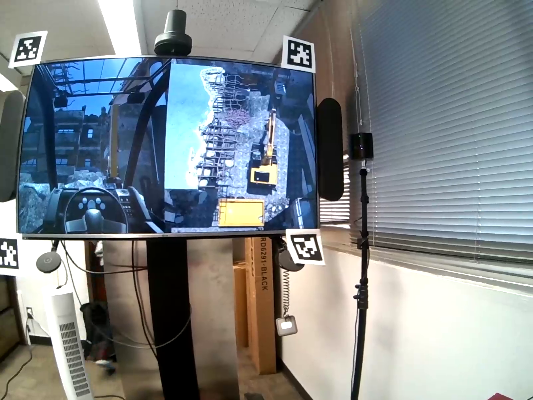


End time: 14:16.119
End frame: 17123


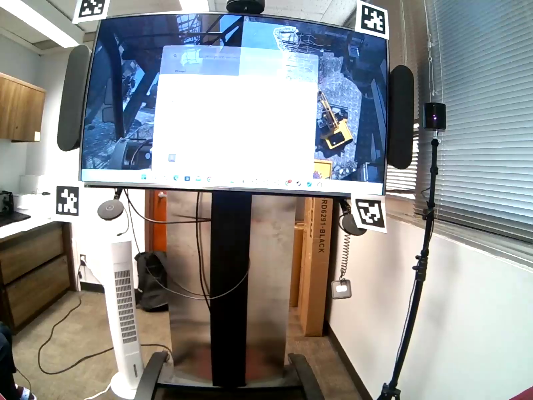

In [ ]:
# TODO: determine the starting and ending time of the time interval to compute
# parameters for

# for this step, simply (1) modify the times below (or using the form), then
# (2) run this cell
# the corresponding frames will appear; (3) repeat until the appropriate frames
# show up
# the frame numbers might be off by 2-3 frames; this is OK
START_TIME_SEC = 620.755 # @param {type: 'number'}
END_TIME_SEC = 856.119 # @param {type: 'number'}

# ex: ADAM MV2 (top): start=565, end=2435
# ex: ADAM MV1 (side): start=2900, end=4252

player.downscale_factor = 3

START_TIME = Time.from_sec(START_TIME_SEC)
player.seek_time(START_TIME)
START_FRAME = player.frame_no()
print(f'Start time: {START_TIME}')
print(f'Start frame: {START_FRAME}')
player.draw()

print()

END_TIME = Time.from_sec(END_TIME_SEC)
player.seek_time(END_TIME)
END_FRAME = player.frame_no()
print(f'End time: {END_TIME}')
print(f'End frame: {END_FRAME}')
player.draw()

START_TIME -= player.offset
END_TIME -= player.offset

## Results

In [ ]:
def fmt_percent(num: int, den: int) -> str:
    '''
    Pretty-prints a fraction as a percentage in the form:

    percent% (num / den)
    '''
    return f'{num / den * 100:.4f}% ({num} / {den})'

In [ ]:
# displays how many timepoints have 0, 1, 2, 3, or 4 marker coordinates set
# the goal is that most of them have 3 to 4 coordinates set

counts = [0, 0, 0, 0, 0]
indices = []
for timepoint in timepoints:
    if START_TIME + timepoints[0].timestamp <= timepoint.timestamp and timepoint.timestamp <= END_TIME + timepoints[0].timestamp:
        counts[timepoint.num_set()] += 1

usable = counts[3] + counts[4]
total = sum(counts)
print(counts)
print(f'{fmt_percent(usable, total)} usable marker coordinates')

[0, 0, 107, 1904, 4756]
98.4188% (6660 / 6767) usable marker coordinates


In [ ]:
# collect gazes where the participant looked in either half of the screen
# the left half is the main view, and the right half is the alternate view

# filter out gaze points outside of our START_TIME and END_TIME
def filter_gaze(gaze: Gaze):
    return START_TIME + timepoints[0].timestamp <= gaze.timestamp and gaze.timestamp <= END_TIME + timepoints[0].timestamp

filtered_gazes = list(filter(filter_gaze, gazes))

looking_left_gazes = []
looking_right_gazes = []

for gaze in filtered_gazes:
    # we have the coordinates of the four markers, which form a box around the
    # screen that the participant is looking at

    # we need to split the box in half vertically and check for fixations
    # within both halves
    marker_coords = get_marker_by_timestamp(gaze.timestamp)

    top_left = marker_coords.top_left
    top_right = marker_coords.top_right
    bottom_right = marker_coords.bottom_right
    bottom_left = marker_coords.bottom_left
    top_middle = lerp_vec(top_left, top_right, 0.5)
    bottom_middle = lerp_vec(bottom_left, bottom_right, 0.5)

    is_looking_left = inside_quad(gaze.point, [top_left, top_middle, bottom_middle, bottom_left])
    is_looking_right = inside_quad(gaze.point, [top_middle, top_right, bottom_right, bottom_middle])
    if is_looking_left:
        looking_left_gazes.append(gaze)
    if is_looking_right:
        looking_right_gazes.append(gaze)

print(f'{fmt_percent(len(filtered_gazes), len(gazes))} of gazes were used')
print(f'{fmt_percent(len(looking_left_gazes), len(filtered_gazes))} of these gazes were on left half')
print(f'{fmt_percent(len(looking_right_gazes), len(filtered_gazes))} of these gazes were on right half')

27.2685% (46748 / 171436) of gazes were used
43.3131% (20248 / 46748) of these gazes were on left half
55.8890% (26127 / 46748) of these gazes were on right half


In [ ]:
# calculate target parameters:
# total fixation duration
# duration of average fixation
# dwells with saccade count

def collect(gazes: list[Gaze]) -> tuple[list[tuple[int, list[Gaze]]], int]:
    '''
    Collects groups of gaze points that are part of a single fixation id.

    Returns a 2-tuple, where the first item (fixations) contains each gaze
    grouped by fixation id, and the second item (saccades) is the saccade count.

    :param gazes: The list of gaze points to process. This will be either the
        left half or right half.
    '''
    fixations = []
    saccades = 0
    current_fixation_id = None
    current_fixated_gazes = []

    for gaze in gazes:
        # there are four possible states
        if gaze.fixation_id == None:
            if current_fixation_id == None:
                # 1. the current `gaze` is in the middle of a saccade, do nothing
                pass
            else:
                # 2. this `gaze` is the first point of a saccade, completing a
                # fixation
                # save this fixation to `fixations`, and also count the saccade
                fixations.append((current_fixation_id, current_fixated_gazes))
                current_fixation_id = None
                current_fixated_gazes = []
                saccades += 1
        else:
            if current_fixation_id == None:
                # 3. this `gaze` is the first point of a fixation, start recording
                # the next gazes that are also part of this same fixation
                current_fixation_id = gaze.fixation_id
                current_fixated_gazes.append(gaze)
            else:
                # 4. the current `gaze` is in the middle of a fixation, record it
                current_fixated_gazes.append(gaze)

    return (fixations, saccades)

def is_fixating(timestamp: Time, fixations: list[tuple[int, list[Gaze]]]) -> bool:
    '''
    Returns true if the participant is fixating at the given timestamp, using
    the provided fixation list for reference.

    :param timestamp: The timestamp to check.
    :param fixations: The fixation list to use. This should be provided by the
        `collect` function.
    '''
    for (fixation_id, gazes) in fixations:
        if gazes[0].timestamp <= timestamp <= gazes[-1].timestamp:
            return True
    return False

def compute_parameters(data: tuple[list[tuple[int, list[Gaze]]], int]) -> tuple[Time, Time, int]:
    '''
    Computes the three target parameters for the given fixation data.

    Returns a 3-tuple containing the total fixation duration, the average
    fixation duration, and the number of saccades, in that order.

    :param data: The fixation list to use. This should be the value directly
        returned by the `collect` function.
    '''
    (fixations, saccades) = data
    total_fixation_duration = Time(0)

    for (fixation_id, gazes) in fixations:
        total_fixation_duration += gazes[-1].timestamp - gazes[0].timestamp

    average_fixation_duration = Time(total_fixation_duration.nanoseconds / len(fixations))
    return (total_fixation_duration, average_fixation_duration, saccades)

main_view_data = collect(looking_left_gazes)
side_view_data = collect(looking_right_gazes)
main_view_result = compute_parameters(main_view_data)
side_view_result = compute_parameters(side_view_data)

# column 0: main view
# column 1: alternate view
data = {
    'Total fixation duration (sec)': [main_view_result[0].sec(), side_view_result[0].sec()],
    'Average fixation duration (sec)': [main_view_result[1].sec(), side_view_result[1].sec()],
    'Saccade count': [main_view_result[2], side_view_result[2]]
}
pd.DataFrame(data).transpose()

0           1
Total fixation duration (sec)     94.473215  124.755309
Average fixation duration (sec)    0.539847    1.113887
Saccade count                    175.000000  112.000000

# TODO: Visualizing the results (optional)

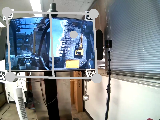

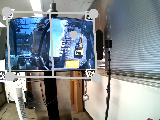

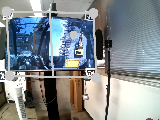

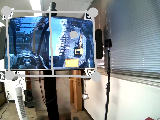

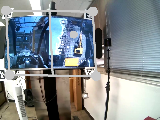

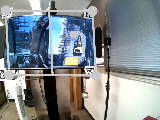

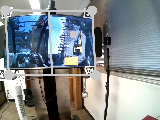

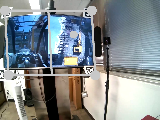

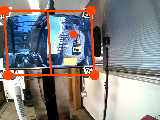

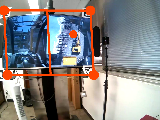

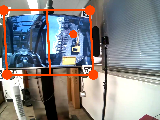

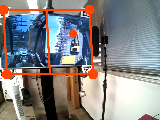

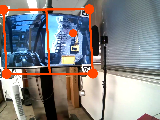

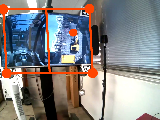

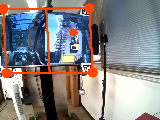

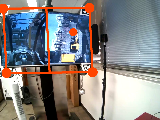

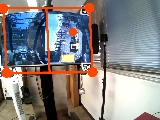

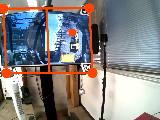

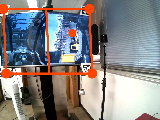

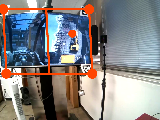

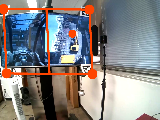

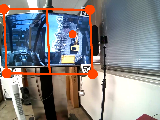

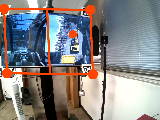

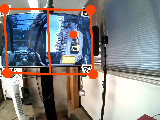

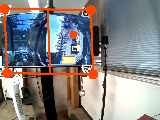

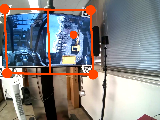

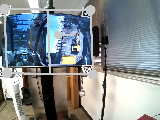

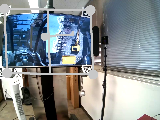

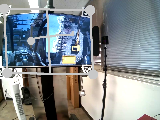

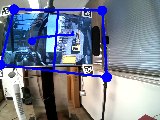

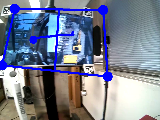

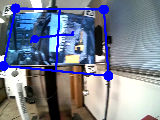

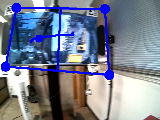

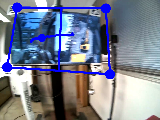

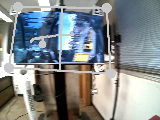

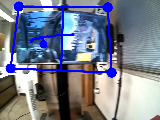

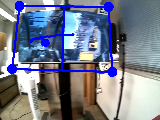

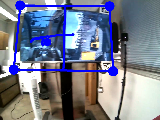

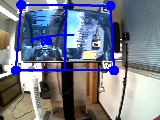

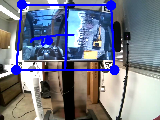

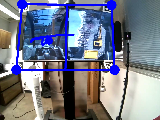

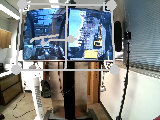

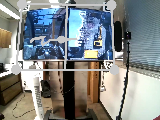

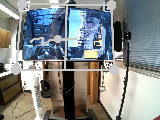

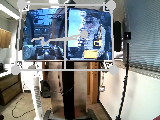

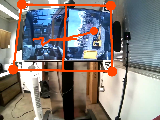

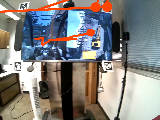

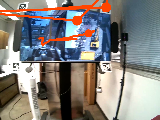

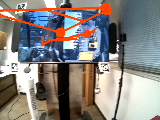

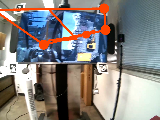

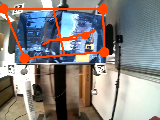

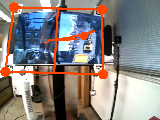

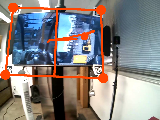

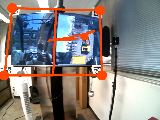

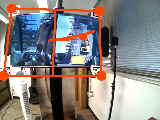

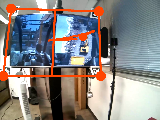

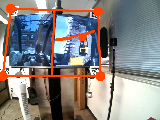

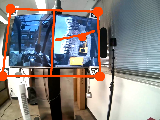

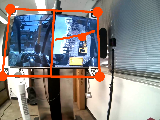

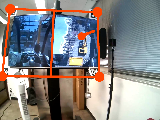

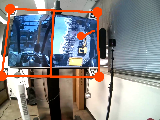

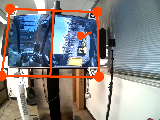

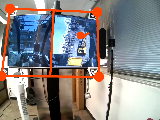

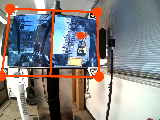

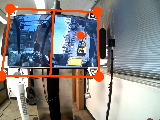

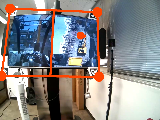

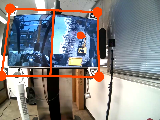

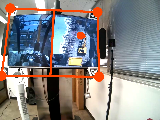

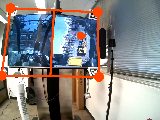

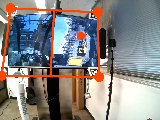

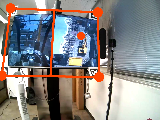

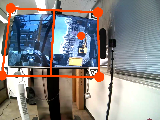

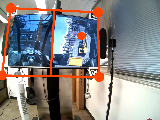

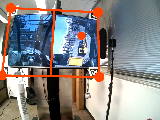

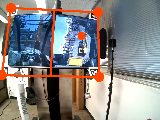

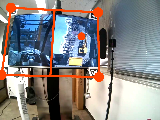

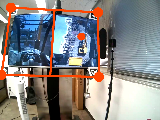

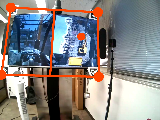

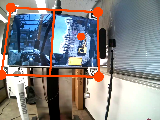

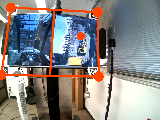

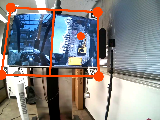

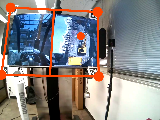

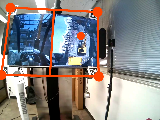

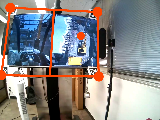

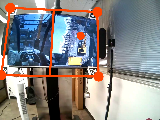

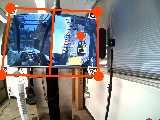

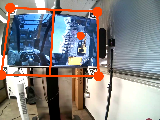

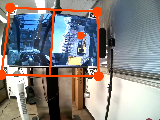

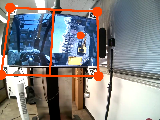

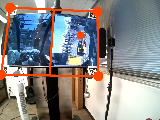

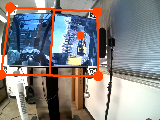

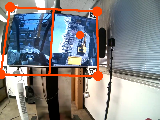

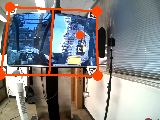

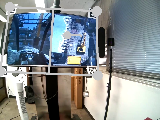

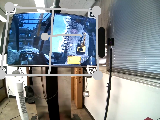

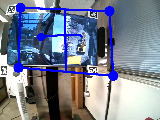

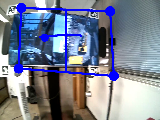

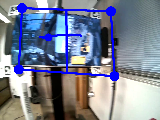

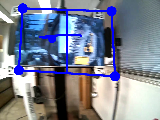

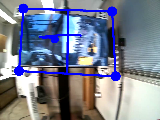

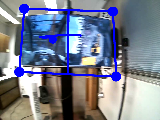

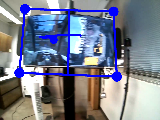

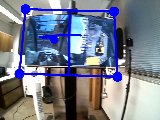

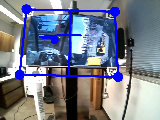

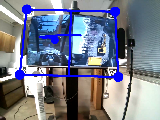

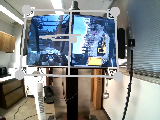

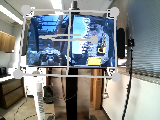

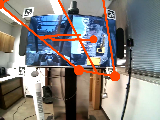

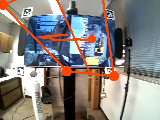

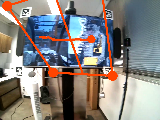

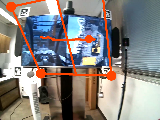

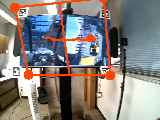

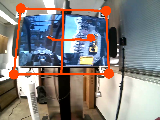

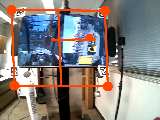

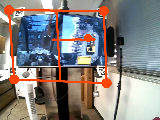

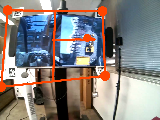

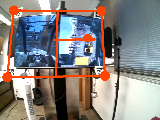

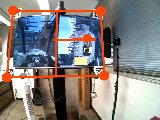

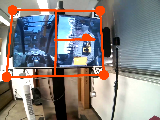

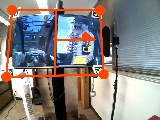

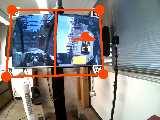

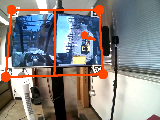

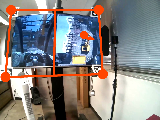

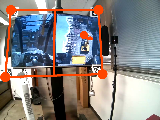

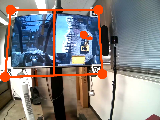

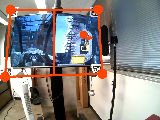

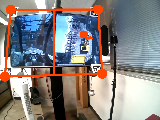

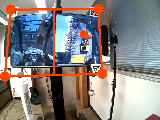

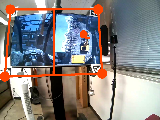

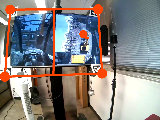

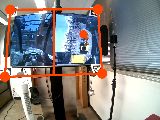

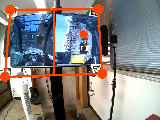

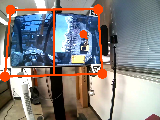

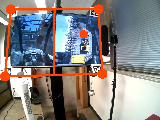

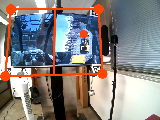

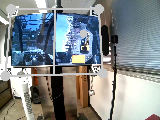

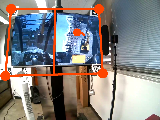

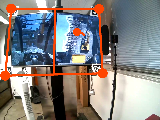

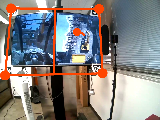

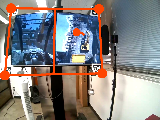

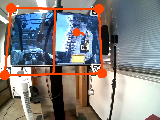

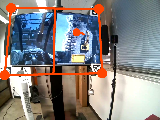

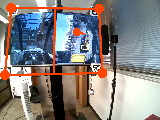

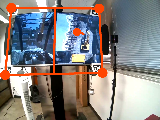

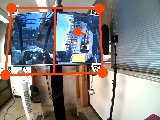

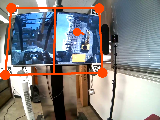

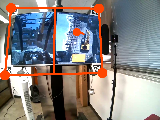

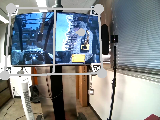

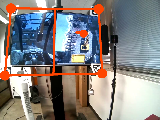

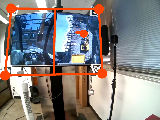

In [ ]:
# visualize points of interest on video
# NOTE: when the participant is fixating on the left half, markers will be drawn blue
# when the participant is fixating on the right half, markers will be drawn orange
# otherwise, the markers will be gray
# NOTE: this cell can be skipped

## TODO: choose number of frames to visualize (150 is most likely good enough)
frames_to_watch = 150

player.downscale_factor = 10
player.seek(START_FRAME)

for i in range(frames_to_watch):
    def draw(image):
        resolved = player.resolved_time() + timepoints[0].timestamp

        if is_fixating(resolved, main_view_data[0]):
            # blue: fixating on main view (left half)
            color = (255, 0, 0)
        elif is_fixating(resolved, side_view_data[0]):
            # orange: fixating on alternate view (right half)
            color = (0, 69, 255)
        else:
            # white
            color = (200, 200, 200)

        # draw participant's gaze for the last second
        def search(timestamp: Time):
            '''
            Gets the gaze point with the time closest to the given timestamp.
            '''
            i = bisect_left(filtered_gazes, timestamp, key=lambda gaze: gaze.timestamp)
            return i

        start_idx = search(resolved - Time.from_ms(500))
        end_idx = search(resolved)
        for i in range(start_idx, end_idx):
            current = as_int(filtered_gazes[i].point)
            next_ = as_int(filtered_gazes[i + 1].point)
            cv2.line(image, current, next_, color, 20)

        cv2.circle(image, as_int(filtered_gazes[end_idx].point), 40, color, -1)

        # draw paper markers
        marker_coords = get_marker_by_timestamp(resolved)
        for coord in marker_coords:
            cv2.circle(image, as_int(coord), 50, color, -1)

        # connect paper markers with lines
        for i in range(len(marker_coords)):
            current = marker_coords[i]
            # i forgot `next` is already a function name
            # this is why you don't global namespace!
            next_ = marker_coords[(i + 1) % len(marker_coords)]

            current_coord = as_int(current)
            next_coord = as_int(next_)
            cv2.line(image, current_coord, next_coord, color, 20)

        # draw line through the middle half of the screen
        top_middle = as_int(lerp_vec(marker_coords.top_left, marker_coords.top_right, 0.5))
        bottom_middle = as_int(lerp_vec(marker_coords.bottom_left, marker_coords.bottom_right, 0.5))
        cv2.line(image, top_middle, bottom_middle, color, 20)

        return image

    player.draw(draw)